# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 69 kB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 127 kB 7.8 MB/s 
     |████████████████████████████████| 813 kB 38.6 MB/s 
     |████████████████████████████████| 242 kB 60.8 MB/s 
     |████████████████████████████████| 678 kB 43.8 MB/s 
     |████████████████████████████████| 211 kB 51.4 MB/s 
     |████████████████████████████████| 1.4 MB 33.0 MB/s 
     |████████████████████████████████| 3.2 MB 52.7 MB/s 
     |████████████████████████████████| 8.8 MB 33.4 MB/s 
     |████████████████████████████████| 2.0 MB 60.1 MB/s 
     |████████████

## Imports and data loading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                   
Downloading...: 24938it [00:00, 78888.86it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                    
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 77306.01it/s]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [5]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(adata.obsm["protein_expression"][batch == "PBMC5k"])

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    batch_key="batch",
    flavor="seurat_v3",
    n_top_genes=4000, 
    subset=True
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


<div class="alert alert-info">

Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

</div>

In [7]:
scvi.model.TOTALVI.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 10849 cells, 4000 vars, 2 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


## Prepare and run model

In [8]:
model = scvi.model.TOTALVI(
    adata, 
    latent_distribution="normal", 
    n_layers_decoder=2
)

In [9]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [11:00<00:00,  1.65s/it, loss=599, v_num=1]


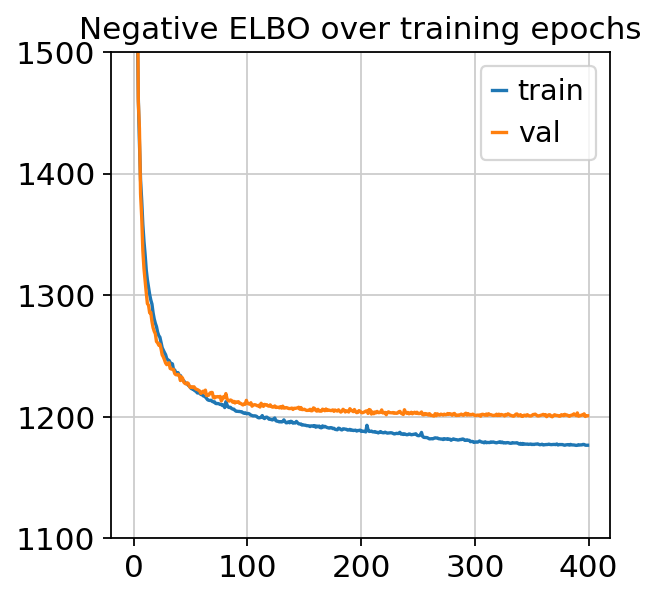

In [10]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [11]:
adata.obsm["X_totalVI"] = model.get_latent_representation()
adata.obsm["protein_fg_prob"] = model.get_protein_foreground_probability(transform_batch="PBMC10k")

rna, protein = model.get_normalized_expression(transform_batch="PBMC10k", n_samples=25, return_mean=True)

<div class="alert alert-info">

Note

`transform_batch` is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"

</div>

In [12]:
protein.iloc[:5, :5]

CD3_TotalSeqB  ...  CD15_TotalSeqB
index                              ...                
AAACCCAAGATTGTGA-1      13.776643  ...      109.560150
AAACCCACATCGGTTA-1      31.085346  ...      107.579414
AAACCCAGTACCGCGT-1      10.900543  ...      117.206902
AAACCCAGTATCGAAA-1       0.596661  ...      126.729347
AAACCCAGTCGTCATA-1       1.097599  ...       94.427673

[5 rows x 5 columns]

<div class="alert alert-info">

Note

The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.

</div>

In [13]:
_, protein_means = model.get_normalized_expression(
    n_samples=25, 
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


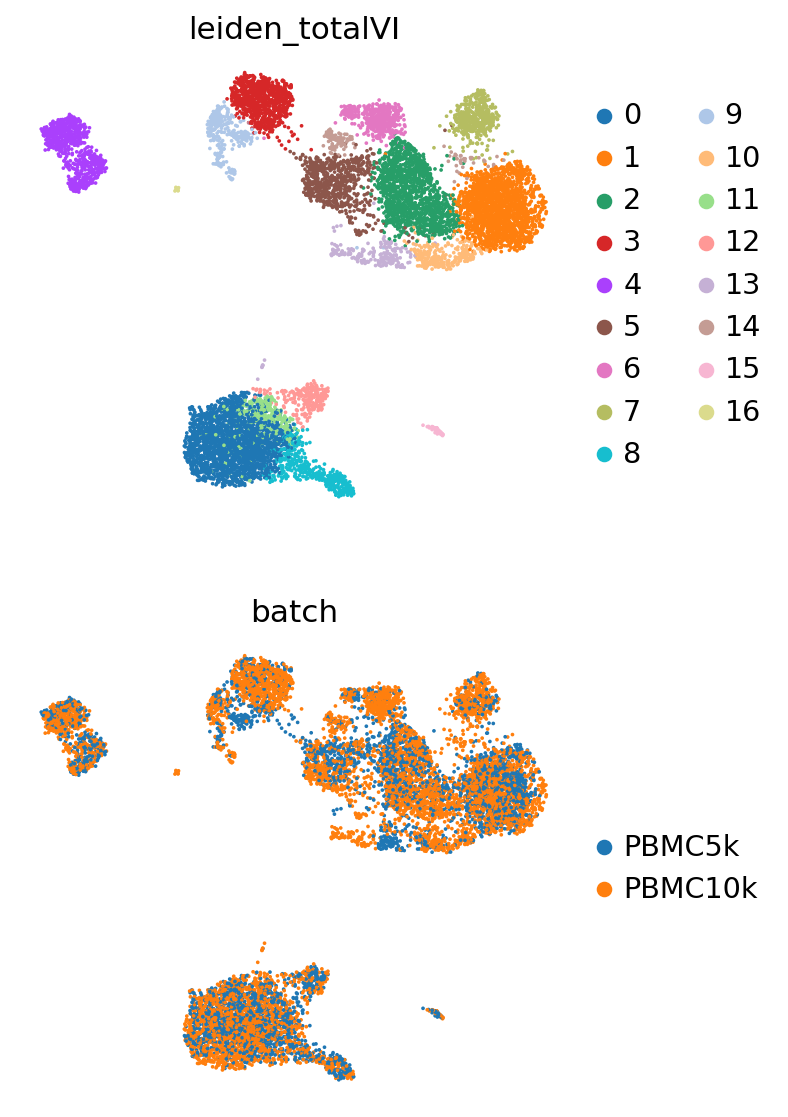

In [15]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds], 
    color=["leiden_totalVI", "batch"],
    ncols=1,
    frameon=False,
)

In [16]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate([adata.obsm["protein_expression"].values[batch=="PBMC10k"], held_out_proteins], axis=0)

# cleaner protein names
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
for i, p in enumerate(parsed_protein_names):
    adata.obs["{} imputed".format(p)] = protein_means.iloc[:, i]
    adata.obs["{} observed".format(p)] = combined_protein[:, i]

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


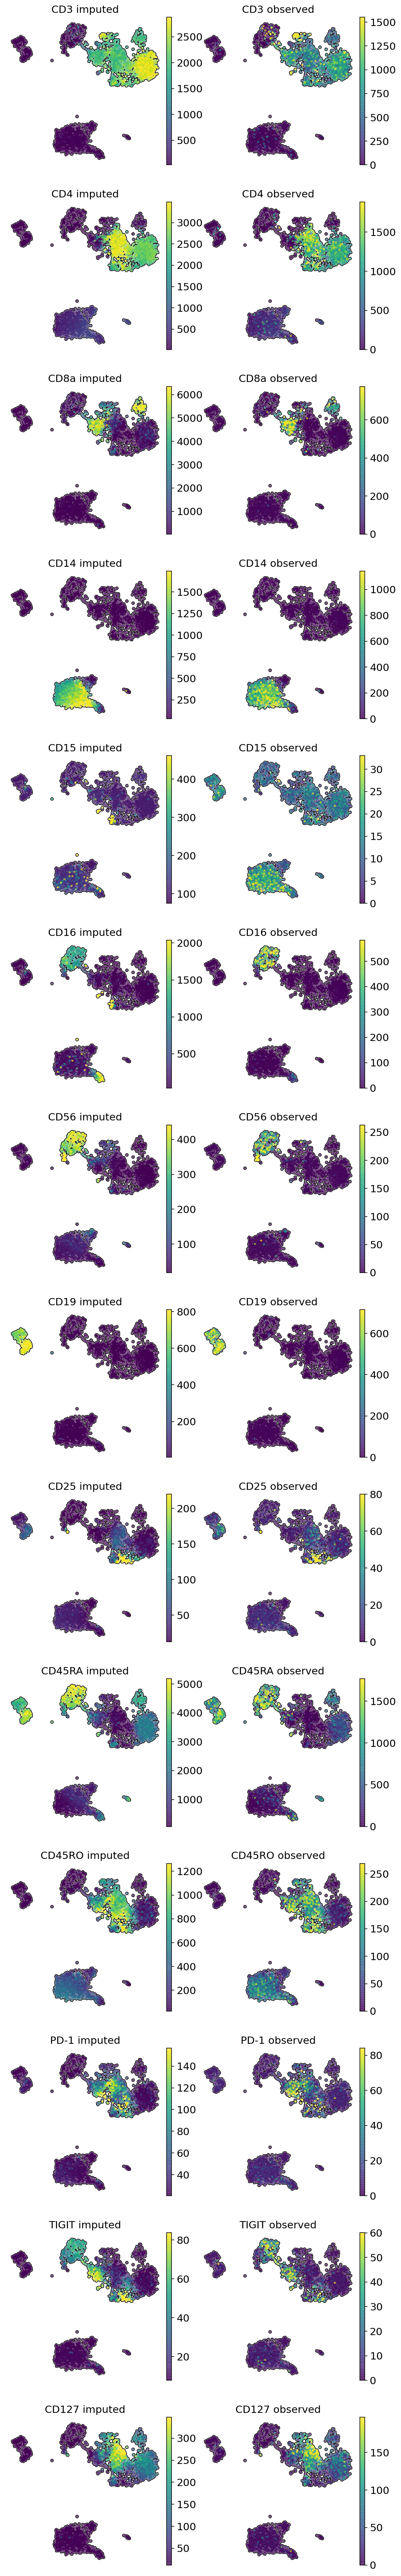

In [17]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1
)

## Imputed vs denoised correlations

In [18]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3)))
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.551565   CD3: Corr=0.786
1        5.105945       5.946287   CD4: Corr=0.877
2        2.833213       3.391618  CD8a: Corr=0.823
3        6.546785       7.193236   CD14: Corr=0.91
4        2.995732       4.842935  CD15: Corr=0.097

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

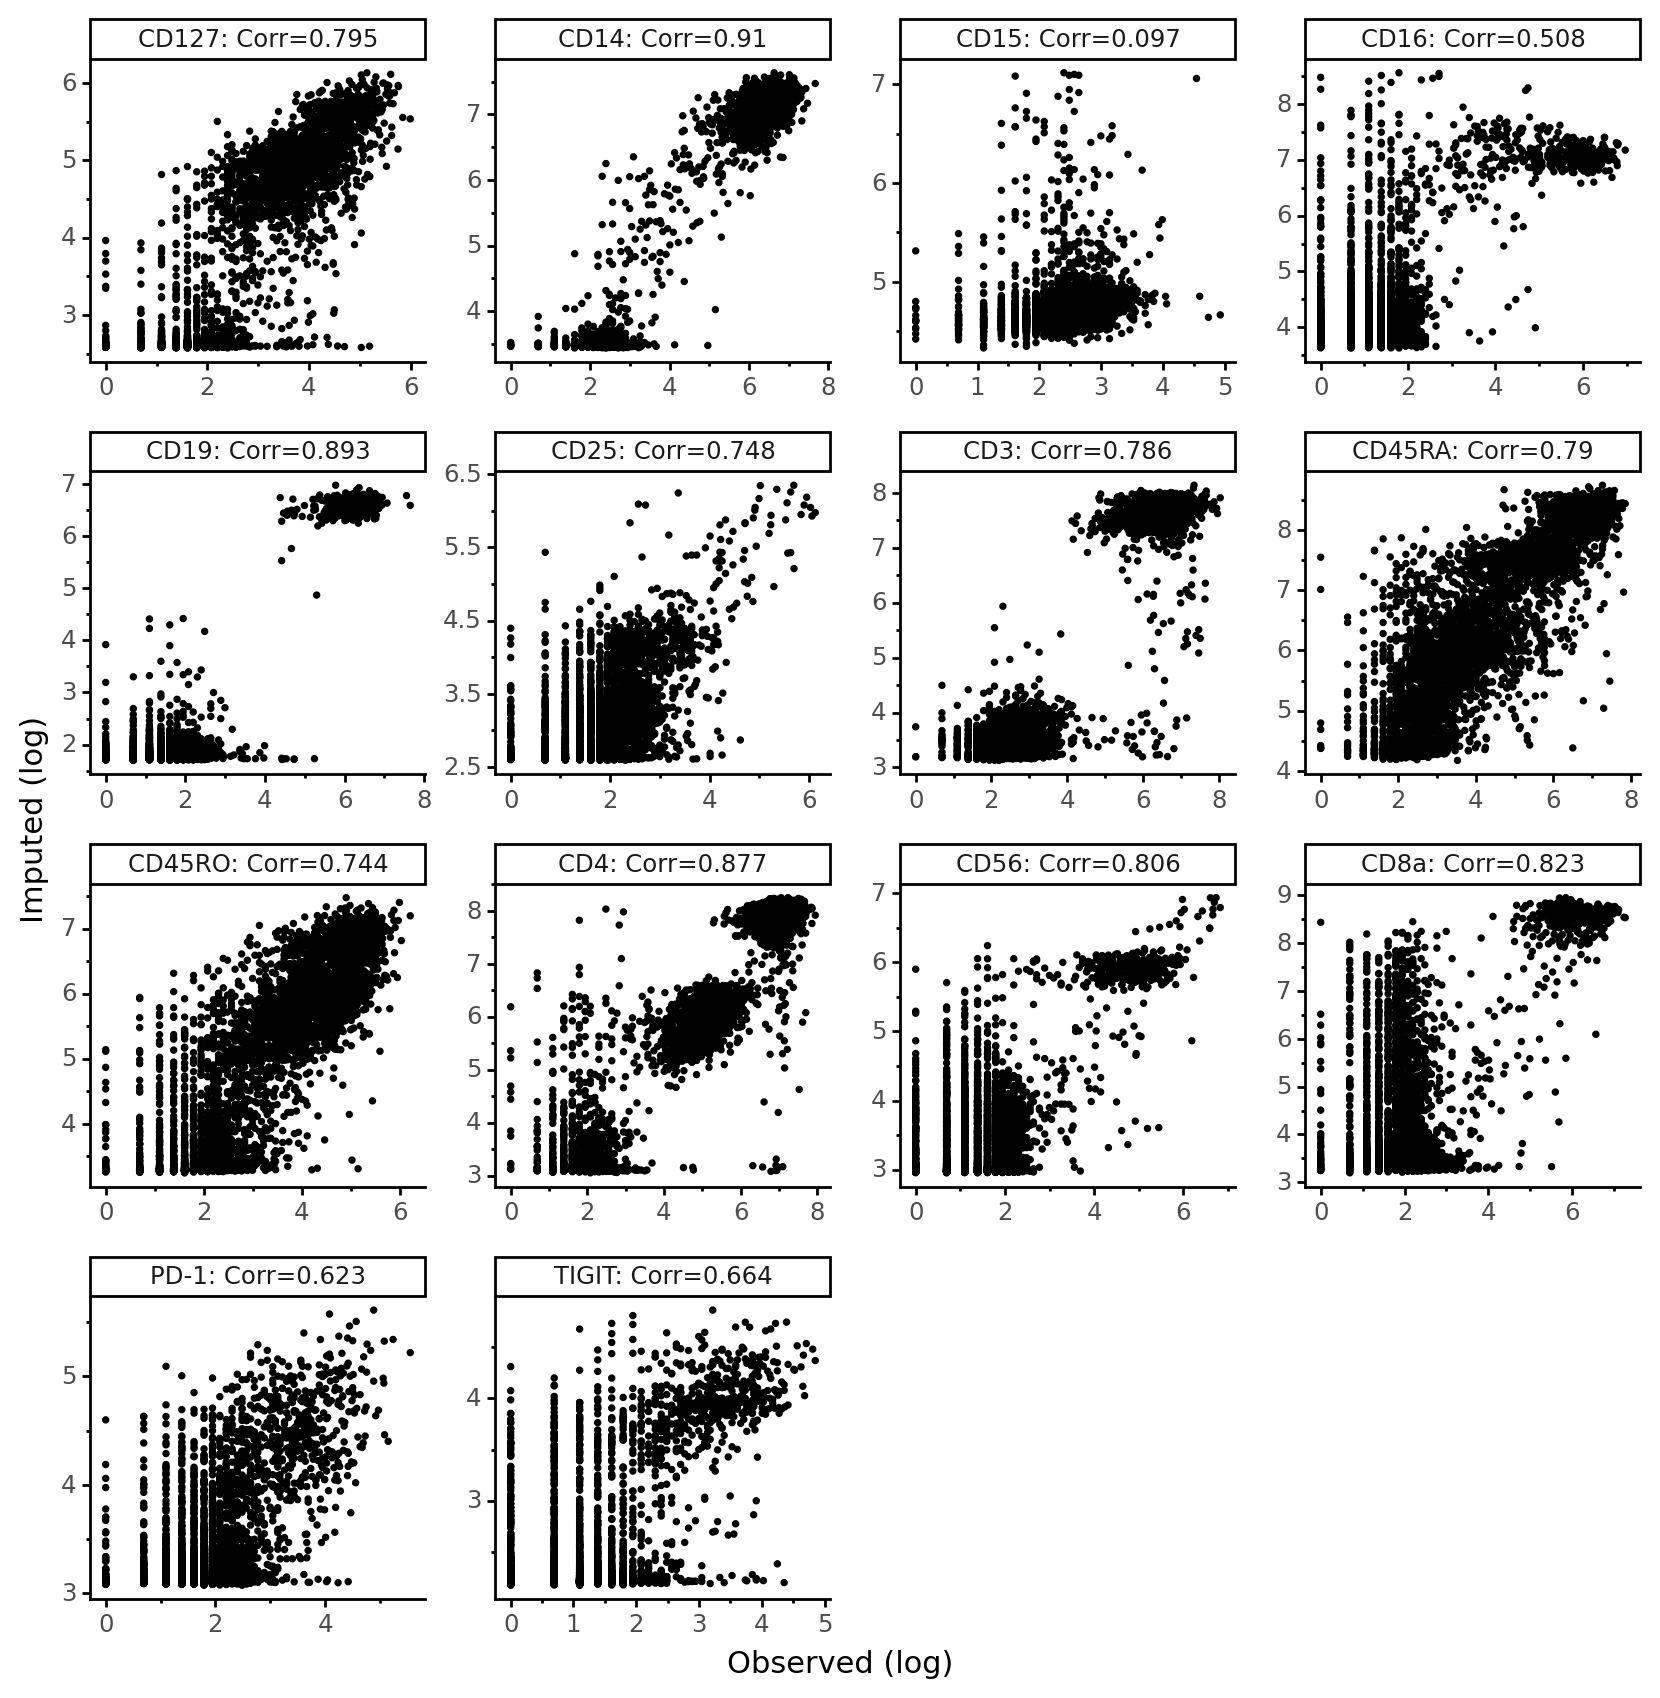

<ggplot: (8793023032337)>

In [19]:
p9.theme_set(p9.theme_classic)
(p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
 + p9.geom_point(size=0.5)
 + p9.facet_wrap("~Protein", scales="free")
 + p9.theme(figure_size=(10, 10), panel_spacing=.35,)
)
